# Basic Python Training
### Python and pandas is extremely well documented. When in doubt, use Google and find the link corresponding to the API here https://pandas.pydata.org/docs/reference/index.html#api

In [2]:
# If the below code doesn't work uncomment this and run (this adds the parent directory to the path)
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [3]:
import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np

## Reading and writing/storing data

### Set up the data library 

In [4]:
dl = DataLib("SignalData")

### Pull and look at the data. See SignalDataLibrary.py for the data available to you from Eikon. Use head and tail to look at the top and bottom of the dataframes.

In [5]:
LongRates = dl.pull('LongRates')
ShortRates = dl.pull('ShortRates')

In [6]:
LongRates.head()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
1980-01,10.08,7.92,NaN,NaN,NaN,NaN,8.64,NaN,13.92,10.33
1980-02,10.45,8.15,NaN,NaN,NaN,NaN,8.50,NaN,13.71,11.29
1980-03,10.55,8.96,NaN,NaN,NaN,NaN,9.32,NaN,13.72,12.79
1980-04,11.20,9.83,NaN,NaN,NaN,NaN,10.00,NaN,13.54,12.69
1980-05,11.73,8.99,NaN,NaN,NaN,NaN,10.30,NaN,13.07,10.57


In [7]:
ShortRates.head()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
1980-01,9.97,NaN,NaN,NaN,NaN,NaN,7.295,NaN,NaN,11.23
1980-02,10.38,8.426,NaN,NaN,NaN,NaN,7.295,NaN,NaN,12.04
1980-03,10.75,9.123,NaN,NaN,NaN,NaN,7.295,NaN,NaN,14.83
1980-04,11.20,10.085,NaN,NaN,NaN,NaN,7.960,NaN,NaN,14.59
1980-05,11.40,9.416,NaN,NaN,NaN,NaN,7.960,NaN,NaN,10.70


### Generate some new data and store it

In [8]:
LongMinusShortRates = LongRates - ShortRates
dl.write_data("LongMinusShortRates", LongMinusShortRates)
LongMinusShortRates.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2020-04,0.472,0.183,0.220,0.845,0.528,1.135,0.141,0.235,0.197,0.401
2020-05,0.668,0.173,0.195,0.838,0.501,1.252,0.132,0.108,0.213,0.438
2020-06,0.619,0.260,0.250,0.988,0.486,1.126,0.170,0.214,0.233,0.504
2020-07,0.660,0.260,0.241,1.000,0.534,1.236,0.186,0.255,0.274,0.518
2020-08,0.583,0.177,0.205,0.713,0.415,1.097,0.158,0.260,0.174,0.448


In [9]:
LongMinusShortRatesFromStorage = dl.pull("LongMinusShortRates")
LongMinusShortRatesFromStorage.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2020-04,0.472,0.183,0.220,0.845,0.528,1.135,0.141,0.235,0.197,0.401
2020-05,0.668,0.173,0.195,0.838,0.501,1.252,0.132,0.108,0.213,0.438
2020-06,0.619,0.260,0.250,0.988,0.486,1.126,0.170,0.214,0.233,0.504
2020-07,0.660,0.260,0.241,1.000,0.534,1.236,0.186,0.255,0.274,0.518
2020-08,0.583,0.177,0.205,0.713,0.415,1.097,0.158,0.260,0.174,0.448


## Basic Data Access

### Select a subset of columns

In [10]:
LongRates[['AUS', 'DEU']].tail()

country,AUS,DEU
date,,
2020-04,0.685,-0.470
2020-05,0.893,-0.586
2020-06,0.896,-0.393
2020-07,0.932,-0.400
2020-08,0.866,-0.522


### Select a subset of data by index name using loc (see the documentation if you're unfamiliar with the ':' operation for slicing)

In [11]:
# Select a list of specific rows
LongRates.loc[[pd.Period('2020-03'), pd.Period('2020-04')], ['AUS', 'DEU']]

country,AUS,DEU
date,,
2020-03,0.786,-0.62
2020-04,0.685,-0.47


In [12]:
# Select a slice of rows
LongRates.loc[pd.Period('2020-03'):pd.Period('2020-07'),['AUS', 'DEU']]

country,AUS,DEU
date,,
2020-03,0.786,-0.620
2020-04,0.685,-0.470
2020-05,0.893,-0.586
2020-06,0.896,-0.393
2020-07,0.932,-0.400


### Select a subset of data by index using iloc 

In [13]:
# Select the last 5 elements
LongRates.iloc[-5:, :]

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2020-04,0.685,-0.470,0.614,0.711,0.013,1.547,0.007,-0.343,0.313,0.635
2020-05,0.893,-0.586,0.525,0.731,-0.105,1.777,-0.026,-0.541,0.248,0.640
2020-06,0.896,-0.393,0.534,0.584,-0.022,1.469,0.007,-0.464,0.232,0.662
2020-07,0.932,-0.400,0.527,0.509,-0.060,1.343,0.048,-0.396,0.212,0.682
2020-08,0.866,-0.522,0.468,0.338,-0.203,1.075,0.025,-0.533,0.100,0.563


## Plotting the data. For this, look up matplotlib documentation

### Plotting all the columns of the dataframe

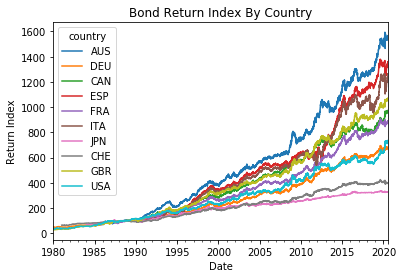

In [14]:
BondReturnIndex = dl.pull('BondRetIdx/LocalFX')
BondReturnIndex.plot()
plt.xlabel('Date')
plt.ylabel('Return Index')
plt.title('Bond Return Index By Country')
plt.show()

### Plot series from different dataframes

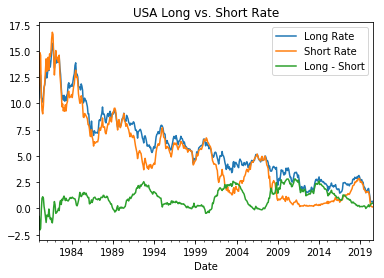

In [16]:
country = 'USA'
LongRates[country].plot()
ShortRates[country].plot()
LongMinusShortRates[country].plot()
plt.legend(['Long Rate', 'Short Rate', 'Long - Short'])
plt.xlabel('Date')
plt.title(f'{country} Long vs. Short Rate')
plt.show()

### Plot multiple charts at the same time. If you want them to all be part of the same figure, check out subplots https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html

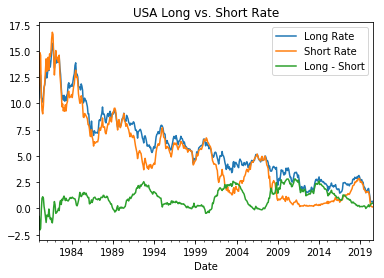

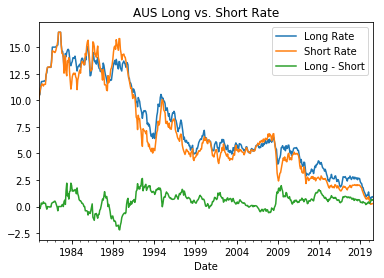

In [17]:
countries = ['USA', 'AUS']
for country in countries:
    LongRates[country].plot()
    ShortRates[country].plot()
    LongMinusShortRates[country].plot()
    plt.legend(['Long Rate', 'Short Rate', 'Long - Short'])
    plt.xlabel('Date')
    plt.title(f'{country} Long vs. Short Rate')
    plt.show()

### Plot on separate axes (look up subplots)

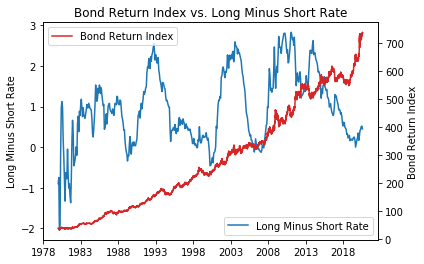

In [18]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Long Minus Short Rate'
ax1.plot(LongMinusShortRates['USA'].to_timestamp(), label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = 'Bond Return Index'
ax2.plot(BondReturnIndex['USA'].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title('Bond Return Index vs. Long Minus Short Rate')
plt.show()

# Useful Operations. (See the time series section of the API)

### Changes (Arithmetic)

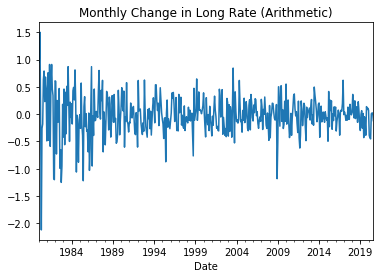

In [19]:
LongRatesMonthlyChange = LongRates.diff()
LongRatesMonthlyChange['USA'].plot()
plt.xlabel("Date")
plt.title("Monthly Change in Long Rate (Arithmetic)")
plt.show()

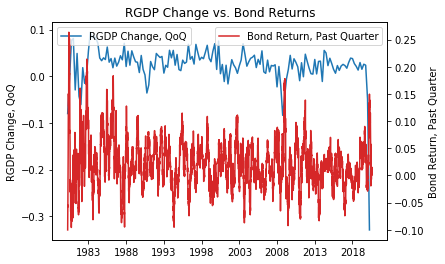

In [20]:
WEEKDAYS_IN_YEAR = 261


RGDP = dl.pull('GDP/Real')
RGDPChangeQoQ_Unannualized = RGDP.pct_change(1, fill_method = None).dropna(how='all')
RGDPChangeQoQ = (RGDPChangeQoQ_Unannualized + 1) ** 4 - 1

BondReturnsPastQuarter = BondReturnIndex.pct_change(int(WEEKDAYS_IN_YEAR / 4))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'RGDP Change, QoQ'
ax1.plot(RGDPChangeQoQ['USA'].to_timestamp(), color = 'tab:blue', label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend(loc=2)
ax2_label = 'Bond Return, Past Quarter'
ax2.plot(BondReturnsPastQuarter['USA'].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title('RGDP Change vs. Bond Returns')
plt.show()

### Rolling Measures (mean and standard deviation)

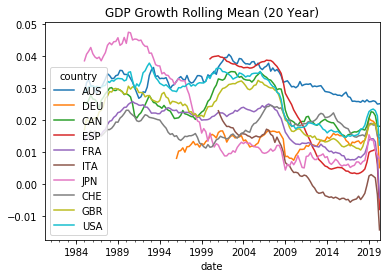

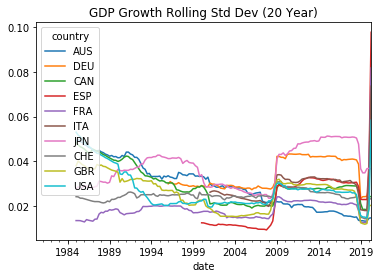

In [21]:
RGDPChangeRollingMean = RGDPChangeQoQ.rolling(40, min_periods=20).mean() # 
RGDPChangeRollingMean.plot()
plt.title('GDP Growth Rolling Mean (20 Year)')
plt.show()
RGDPChangeRollingStdDev = RGDPChangeQoQ.rolling(40, min_periods=20).std()
RGDPChangeRollingStdDev.plot()
plt.title('GDP Growth Rolling Std Dev (20 Year)')
plt.show()

### Working with different frequencies

### Upsampling

In [28]:
pd.options.display.float_format = '{:,.2f}'.format
RGDPChange_Upsampled = RGDPChangeQoQ.resample('1B').ffill()
RGDPChange_Upsampled.head()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
1980-04,0.01,nan,-0.00,nan,-0.02,nan,-0.03,0.01,-0.08,-0.08
1980-05,0.01,nan,-0.00,nan,-0.02,nan,-0.03,0.01,-0.08,-0.08
1980-06,0.01,nan,-0.00,nan,-0.02,nan,-0.03,0.01,-0.08,-0.08
1980-07,0.02,nan,-0.00,nan,-0.00,nan,0.09,0.03,-0.00,-0.00
1980-08,0.02,nan,-0.00,nan,-0.00,nan,0.09,0.03,-0.00,-0.00


### Downsampling

In [23]:
RGDPChange_Downsampled = RGDPChangeQoQ.resample('1Y').mean()
RGDPChange_Downsampled.head()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
1980,0.03,nan,0.02,nan,-0.01,nan,0.05,0.02,-0.04,-0.00
1981,0.04,nan,0.02,nan,0.02,nan,0.03,0.01,0.01,0.01
1982,-0.02,nan,-0.04,nan,0.02,nan,0.04,-0.02,0.02,-0.01
1983,0.03,nan,0.06,nan,0.01,nan,0.04,0.02,0.05,0.08
1984,0.05,nan,0.06,nan,0.02,nan,0.04,0.04,0.03,0.06


### Aggregations across columns

In [24]:
all_countries = RGDPChangeQoQ.columns
RGDPChangeMeans = RGDPChangeQoQ.copy()
RGDPChangeMeans['Equal Weighted Mean'] = RGDPChangeQoQ.mean(axis=1)
RGDPChangeMeans.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA,Equal Weighted Mean
date,,,,,,,,,,,
2019Q2,0.02,-0.02,0.03,0.02,0.01,0.00,0.02,0.01,-0.00,0.01,0.01
2019Q3,0.02,0.01,0.01,0.02,0.01,0.00,0.00,0.02,0.02,0.03,0.01
2019Q4,0.02,-0.00,0.01,0.02,-0.01,-0.01,-0.07,0.01,-0.00,0.02,-0.00
2020Q1,-0.01,-0.08,-0.08,-0.19,-0.22,-0.20,-0.02,-0.10,-0.08,-0.05,-0.10
2020Q2,nan,-0.35,nan,-0.56,-0.45,-0.41,nan,nan,nan,-0.33,-0.42


In [25]:
random_weights = {country: np.random.uniform() for country in all_countries}
RGDPChangeMeans['Random Weighted Mean'] = sum([random_weights[country] * RGDPChangeQoQ[country] for country in countries])
RGDPChangeMeans['Random Weighted Mean'] /= sum(random_weights.values()) # Need to either do this or normalize the weights
RGDPChangeMeans.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA,Equal Weighted Mean,Random Weighted Mean
date,,,,,,,,,,,,
2019Q2,0.02,-0.02,0.03,0.02,0.01,0.00,0.02,0.01,-0.00,0.01,0.01,0.00
2019Q3,0.02,0.01,0.01,0.02,0.01,0.00,0.00,0.02,0.02,0.03,0.01,0.01
2019Q4,0.02,-0.00,0.01,0.02,-0.01,-0.01,-0.07,0.01,-0.00,0.02,-0.00,0.01
2020Q1,-0.01,-0.08,-0.08,-0.19,-0.22,-0.20,-0.02,-0.10,-0.08,-0.05,-0.10,-0.01
2020Q2,nan,-0.35,nan,-0.56,-0.45,-0.41,nan,nan,nan,-0.33,-0.42,nan


## Exercise
### Calculate the rolling 1-year return of a world bond portfolio that is weighted by GDP of each country. Say that you instantly rebalance at the beginning of each quarter with the GDP from last quarter.